# 実践コンピュータビジョン
# 3章 画像間の写像
## 3.3 パノラマの作成
テキストp.72

撮影した写真の重なる点と撮影の方向を推定し、画像をつないだパノラマを作成する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
from scipy import ndimage
import os

In [3]:
import sift
import warp
import homography

/Users/takeshi/anaconda/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [4]:
featname = ['univ/Univ'+str(i+1)+'.sift' for i in range(5)]
imname = ['univ/Univ'+str(i+1)+'.jpg' for i in range(5)]

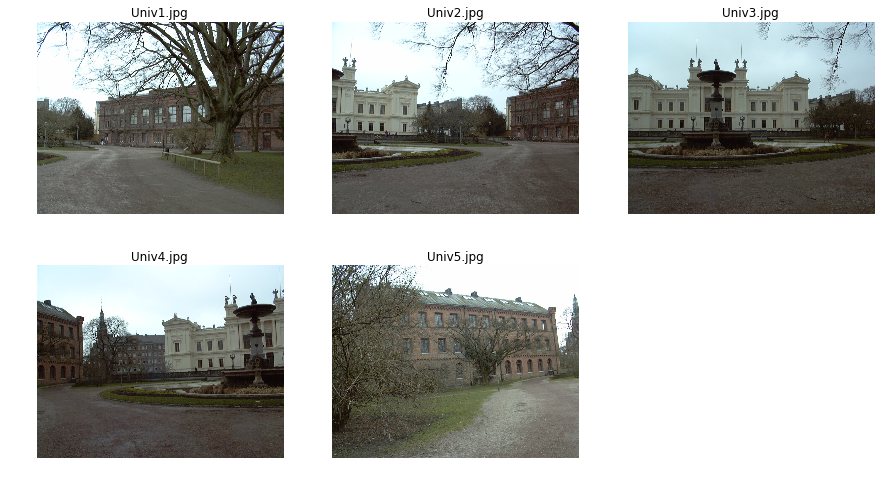

In [5]:
# 大学構内の写真５枚を表示する
plt.figure(figsize=(15,8))
for i in range(5):
    im = np.array(Image.open(imname[i]))
    plt.subplot(2,3,i+1)
    plt.imshow(im)
    plt.title('Univ'+str(i+1)+'.jpg')
    plt.axis('off')
plt.show()

In [6]:
# ５枚の画像のSIFT特徴量を計算し、
# SIFT特徴量から座標と記述子を抽出する
l = {}
d = {}
for i in range(5):
    sift.process_image(imname[i],featname[i])
    l[i],d[i] = sift.read_features_from_file(featname[i])
    l[i][:,[0,1]] = l[i][:,[1,0]] # x,y --> row,col

matches = {}
for i in range(4):
    matches[i] = sift.match(d[i+1],d[i])

processed tmp.pgm to univ/Univ1.sift
processed tmp.pgm to univ/Univ2.sift
processed tmp.pgm to univ/Univ3.sift
processed tmp.pgm to univ/Univ4.sift
processed tmp.pgm to univ/Univ5.sift


In [7]:
# 対応点を同次座標の点に変換する関数
def convert_points(j): 
    ndx = matches[j].nonzero()[0]
    fp = homography.make_homog(l[j+1][ndx,:2].T)
    ndx2 = [int(matches[j][i]) for i in ndx]
    tp = homography.make_homog(l[j][ndx2,:2].T)
    return fp,tp

In [8]:
# ホモグラフィーを推定
model = homography.RansacModel()

fp,tp = convert_points(1)
H_12 = homography.H_from_ransac(fp,tp,model)[0] #画像1から2へ

fp,tp = convert_points(0)
H_01 = homography.H_from_ransac(fp,tp,model)[0] #画像0から1へ

tp,fp = convert_points(2) #注意: 順番が逆転
H_32 = homography.H_from_ransac(fp,tp,model)[0] #画像3から2へ

tp,fp = convert_points(3) #注意: 順番が逆転
#H_43 = homography.H_from_ransac(fp,tp,model,match_threshold=3000)[0] #画像4から3へ
H_43 = homography.H_from_ransac(fp,tp,model)[0] #画像4から3へ

/Users/takeshi/pyworks/pcv/pcv_note/chap3/homography.py:154: RuntimeWarning: invalid value encountered in true_divide
  row /= points[-1]
/Users/takeshi/pyworks/pcv/pcv_note/chap3/ransac.py:87: RuntimeWarning: invalid value encountered in less
  also_idxs = test_idxs[test_err < t] # select indices of rows with accepted points
/Users/takeshi/pyworks/pcv/pcv_note/chap3/homography.py:154: RuntimeWarning: divide by zero encountered in true_divide
  row /= points[-1]


In [9]:
# 画像を変形する
im1 = np.array(Image.open(imname[1]))
delta = im1.shape[1] # 領域追加と水平移動量

im2 = np.array(Image.open(imname[2]))
im_12 = warp.panorama(H_12,im1,im2,delta,delta)

im1 = np.array(Image.open(imname[0]))
im_02 = warp.panorama(np.dot(H_12,H_01),im1,im_12,delta,delta)

im1 = np.array(Image.open(imname[3]))
im_32 = warp.panorama(H_32,im1,im_02,delta,delta)

im1 = np.array(Image.open(imname[4]))
im_42 = warp.panorama(np.dot(H_32,H_43),im1,im_32,delta,2*delta)

warp - right
warp - right
warp - left
warp - left


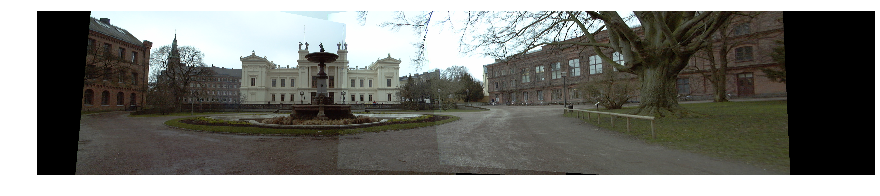

In [10]:
plt.figure(figsize= (15,10))
plt.imshow(np.uint8(im_32))
plt.axis('off')
plt.show()

In [11]:
tp,fp = convert_points(3) #注意: 順番が逆転
#H_43 = homography.H_from_ransac(fp,tp,model,match_threshold=3000)[0] #画像4から3へ
H_43 = homography.H_from_ransac(fp,tp,model)[0] #画像4から3へ

/Users/takeshi/pyworks/pcv/pcv_note/chap3/homography.py:154: RuntimeWarning: divide by zero encountered in true_divide
  row /= points[-1]
/Users/takeshi/pyworks/pcv/pcv_note/chap3/homography.py:154: RuntimeWarning: invalid value encountered in true_divide
  row /= points[-1]
/Users/takeshi/pyworks/pcv/pcv_note/chap3/ransac.py:87: RuntimeWarning: invalid value encountered in less
  also_idxs = test_idxs[test_err < t] # select indices of rows with accepted points


In [12]:
im1 = np.array(Image.open(imname[4]))
im_42 = warp.panorama(np.dot(H_43,H_32),im1,im_32,delta,2*delta)

warp - left


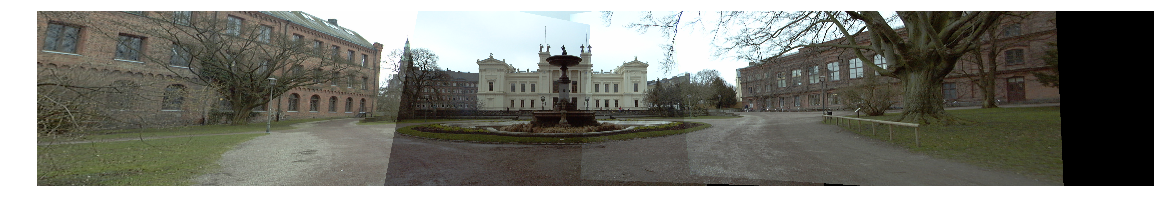

In [13]:
plt.figure(figsize= (20,20))
plt.imshow(np.uint8(im_42))
plt.axis('off')
plt.show()

教科書の例と比べると、一番左の写真の貼り方が異なるが、一応パノラマ写真になった。